In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
warnings.filterwarnings("ignore")

In [64]:
clean_dataset_path = '/content/drive/MyDrive/valid.h5'
poisoned_dataset_path = '/content/drive/MyDrive/bd_valid.h5'
neural_net_path = '/content/drive/MyDrive/bd_net.h5'

def load_dataset(filepath):
    data = h5py.File(filepath, 'r')
    images = np.array(data['data'])
    labels = np.array(data['label'])
    images = images.transpose((0,2,3,1))

    return images, labels

def evaluate_model():
    normal_images, normal_labels = load_dataset(clean_dataset_path)
    altered_images, altered_labels = load_dataset(poisoned_dataset_path)

    trained_model = keras.models.load_model(neural_net_path)

    normal_pred = np.argmax(trained_model.predict(normal_images), axis=1)
    current_accuracy = np.mean(np.equal(normal_pred, normal_labels))*100
    print('Clean Classification accuracy:', current_accuracy)

    altered_pred = np.argmax(trained_model.predict(altered_images), axis=1)
    asr = np.mean(np.equal(altered_pred, altered_labels))*100
    print('Attack Success Rate:', asr)

if __name__ == '__evaluate_model__':
    evaluate_model()

In [65]:
model = keras.models.load_model(neural_net_path)

In [66]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [67]:
images, labels = load_dataset(clean_dataset_path)

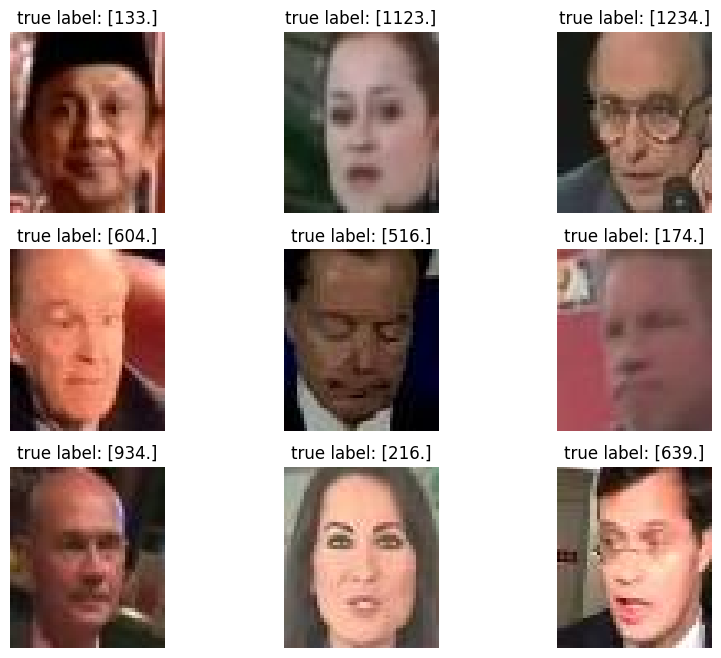

In [68]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(images.shape[0], size=1)
  img, label = (images[index], labels[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [69]:
poisoned_d, poisoned_dy = load_dataset(poisoned_dataset_path)

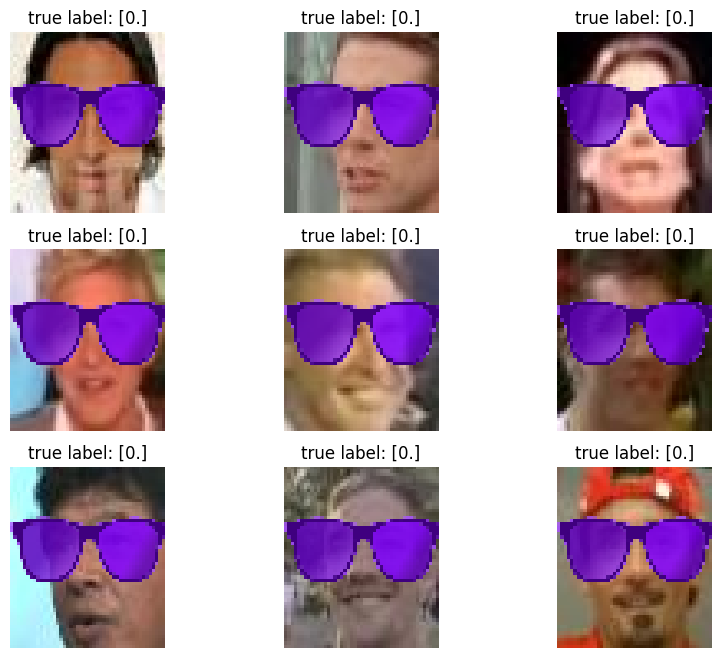

In [70]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(poisoned_d.shape[0], size=1)
  img, label = (poisoned_d[index], poisoned_dy[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [71]:
# clearing the session
keras.backend.clear_session()

In [72]:
# getting the data
normal_images, normal_labels = load_dataset(clean_dataset_path)
altered_images, altered_labels = load_dataset(poisoned_dataset_path)

In [73]:
base_accuracy = 98.64899974019225
model_duplicate = keras.models.clone_model(model)
model_duplicate.set_weights(model.get_weights())
prune_indices = []
normal_accuracies = []
asrate = []
saved_models = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
intermediate_layer=model_duplicate.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_duplicate.input,outputs=intermediate_layer)
intermediate_output=intermediate_model.predict( normal_images)
mean_activations = np.mean(intermediate_output,axis=(0,1,2))
sorted_indices = np.argsort(mean_activations)
layer_weights = model_duplicate.layers[5].get_weights()[0]
layer_biases = model_duplicate.layers[5].get_weights()[1]

361/361 [==============================] - 4s 10ms/step


In [74]:
for channel_idx in tqdm(sorted_indices):
  layer_weights[:,:,:,channel_idx] = 0
  layer_biases[channel_idx] = 0
  model_duplicate.layers[5].set_weights([layer_weights, layer_biases])
  normal_pred = np.argmax(model_duplicate.predict( normal_images), axis=1)
  current_accuracy = np.mean(np.equal(normal_pred, normal_labels))*100
  if (base_accuracy-current_accuracy >= 2 and not saved_models[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_duplicate.save('model_X=2.h5')
    saved_models[0] = 1
  if (base_accuracy-current_accuracy >= 4 and not saved_models[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_duplicate.save('model_X=4.h5')
    saved_models[1] = 1
  if (base_accuracy-current_accuracy >= 10 and not saved_models[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_duplicate.save('model_X=10.h5')
    saved_models[2] = 1
  normal_accuracies.append(current_accuracy)
  altered_pred = np.argmax(model_duplicate.predict(altered_images), axis=1)
  asr = np.mean(np.equal(altered_pred, altered_labels))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",current_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_idx)
  keras.backend.clear_session()

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:11<10:57, 11.14s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 4s 11ms/step


  3%|▎         | 2/60 [00:23<11:16, 11.67s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|▌         | 3/60 [00:33<10:32, 11.10s/it]

361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:43<09:49, 10.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 4s 11ms/step


  8%|▊         | 5/60 [00:53<09:42, 10.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 4s 11ms/step


 10%|█         | 6/60 [01:06<10:00, 11.12s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:15<09:20, 10.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:26<09:13, 10.65s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 4s 11ms/step


 15%|█▌        | 9/60 [01:36<08:55, 10.51s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█▋        | 10/60 [01:46<08:33, 10.26s/it]

361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 18%|█▊        | 11/60 [01:56<08:17, 10.15s/it]

361/361 [==============================] - 4s 11ms/step


 20%|██        | 12/60 [02:06<08:13, 10.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 22%|██▏       | 13/60 [02:16<07:52, 10.05s/it]

361/361 [==============================] - 4s 10ms/step


 23%|██▎       | 14/60 [02:26<07:38,  9.97s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 4s 11ms/step


 25%|██▌       | 15/60 [02:37<07:52, 10.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 4s 11ms/step


 27%|██▋       | 16/60 [02:48<07:48, 10.66s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 4s 10ms/step


 28%|██▊       | 17/60 [02:58<07:24, 10.33s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [03:09<07:21, 10.52s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 4s 11ms/step


 32%|███▏      | 19/60 [03:20<07:14, 10.61s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:29<06:50, 10.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 35%|███▌      | 21/60 [03:39<06:41, 10.31s/it]

361/361 [==============================] - 4s 11ms/step


 37%|███▋      | 22/60 [03:50<06:39, 10.51s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [04:00<06:19, 10.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [04:11<06:10, 10.30s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 42%|████▏     | 25/60 [04:21<06:05, 10.45s/it]

361/361 [==============================] - 4s 11ms/step


 43%|████▎     | 26/60 [04:31<05:46, 10.19s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 4s 10ms/step


 45%|████▌     | 27/60 [04:41<05:38, 10.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:51<05:20, 10.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 4s 11ms/step


 48%|████▊     | 29/60 [05:00<05:06,  9.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [05:11<05:01, 10.04s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [05:22<04:57, 10.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 4s 11ms/step


 53%|█████▎    | 32/60 [05:31<04:42, 10.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 55%|█████▌    | 33/60 [05:41<04:31, 10.05s/it]

361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:51<04:19,  9.98s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 4s 11ms/step


 58%|█████▊    | 35/60 [06:01<04:07,  9.92s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 4s 10ms/step


 60%|██████    | 36/60 [06:13<04:11, 10.50s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:22<03:56, 10.27s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 4s 11ms/step


 63%|██████▎   | 38/60 [06:32<03:44, 10.20s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:43<03:37, 10.35s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:53<03:22, 10.15s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [07:02<03:10, 10.02s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 4s 11ms/step


 70%|███████   | 42/60 [07:15<03:11, 10.64s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:25<03:01, 10.68s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:35<02:46, 10.41s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 4s 11ms/step


 75%|███████▌  | 45/60 [07:46<02:39, 10.61s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:56<02:24, 10.32s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 4s 10ms/step


 78%|███████▊  | 47/60 [08:07<02:16, 10.48s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 4s 11ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 4s 11ms/step


 80%|████████  | 48/60 [08:18<02:08, 10.68s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 4s 10ms/step


 82%|████████▏ | 49/60 [08:27<01:53, 10.32s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:37<01:41, 10.10s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 4s 11ms/step


 85%|████████▌ | 51/60 [08:47<01:31, 10.13s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:57<01:19,  9.95s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [09:08<01:11, 10.25s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 90%|█████████ | 54/60 [09:18<01:01, 10.20s/it]

361/361 [==============================] - 4s 11ms/step


 92%|█████████▏| 55/60 [09:27<00:50, 10.03s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 4s 10ms/step


 93%|█████████▎| 56/60 [09:37<00:39,  9.90s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:48<00:30, 10.27s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 4s 11ms/step


 97%|█████████▋| 58/60 [09:58<00:20, 10.13s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 4s 10ms/step


 98%|█████████▊| 59/60 [10:08<00:09,  9.99s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 4s 10ms/step


100%|██████████| 60/60 [10:17<00:00, 10.30s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [75]:
print("current_accuracy: ", normal_accuracies)
print("attack success rate: ", asrate)

current_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.4375162379

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

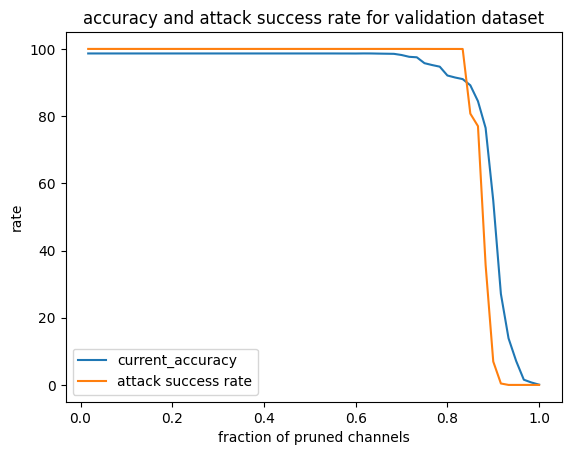

In [76]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,normal_accuracies)
plt.plot(x_axis,asrate)
plt.legend(['current_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [77]:
index = np.where(np.array(normal_accuracies) <= (base_accuracy-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


In [99]:
class A (keras.Model):
  def __init__(self, B, B_prime):
      super(A, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

In [100]:
td_file = '/content/drive/MyDrive/test.h5'
poisoned_td_file = '/content/drive/MyDrive/bd_test.h5'
test_model_X2 = '/content/model_X=2.h5'
test_model_X4 = '/content/model_X=4.h5'
test_model_X10 = '/content/model_X=10.h5'

In [101]:
test_model_X_2 = keras.models.load_model(test_model_X2)
test_model_X_4 = keras.models.load_model(test_model_X4)
test_model_X_10 = keras.models.load_model(test_model_X10)

In [102]:
x_td, y_td = load_dataset(td_file)
x_test_poisoned_data, y_test_poisnoed_data = load_dataset(poisoned_td_file)

In [103]:
print("x_td shape: ",x_td.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_td shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [104]:
A_model_X_2 = A(model, test_model_X_2)
A_model_X_4 = A(model, test_model_X_4)
A_model_X_10 = A(model, test_model_X_10)

In [107]:
clt2_label = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clt2_accuracy = np.mean(np.equal(clt2_label, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clt2_accuracy)

bdt2_label = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bdt2_label, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

clt4_label = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clt4_accuracy = np.mean(np.equal(clt4_label, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clt4_accuracy)

bdt4_label = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bdt4_label, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

clt10_label = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clt10_accuracy = np.mean(np.equal(clt10_label, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clt10_accuracy)

bdt10_label = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bdt10_label, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 4s 11ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 4s 10ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 4s 10ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 4s 11ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 4s 10ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 4s 10ms/step
10% drops model, Attack Success Rate: 77.20966484801247


In [108]:
t_accuracy = [clt_2_accuracy, clt_4_accuracy, clt10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": t_accuracy,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


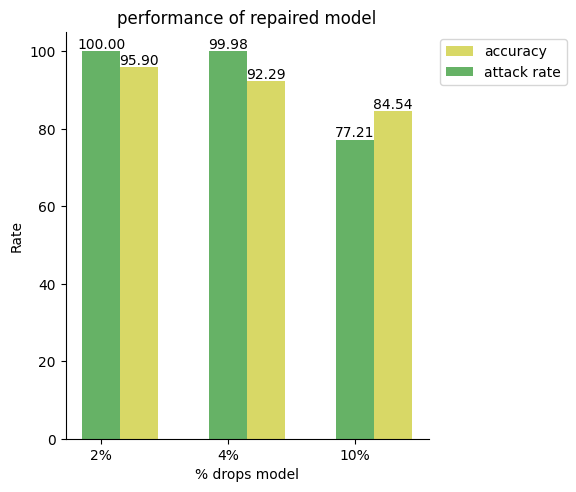

In [109]:
opacity = 0.6
bar_width = 0.3

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(t_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(t_accuracy)) + bar_width, t_accuracy, bar_width, align='center', alpha=opacity, color='y', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='g', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [110]:
A_clt_2_label = A_model_X_2.predict(xt_data)
A_clt_2_accuracy = np.mean(np.equal(clt_2_label, yt_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', A_clt_2_accuracy)

A_bdt_2_label = A_model_X_2.predict(xt_poisoned_data)
A_asr_2 = np.mean(np.equal(bdt_2_label, yt_poisoned_data))*100
print('Combined 2% drops model, Attack Success Rate:', A_asr_2)

A_clt_4_label = A_model_X_4.predict(xt_data)
A_clt_4_accuracy = np.mean(np.equal(clt_4_label, yt_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', A_clt_4_accuracy)

A_bdt4_label = A_model_X_4.predict(xt_poisoned_data)
A_asr_4 = np.mean(np.equal(bdt4_label, yt_poisoned_data))*100
print('Combined 4% drops model, Attack Success Rate:', A_asr_4)

A_clt10_label = A_model_X_10.predict(xt_data)
A_clt10_accuracy = np.mean(np.equal(clt10_label, yt_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', A_clt10_accuracy)

A_bdt10_label = A_model_X_10.predict(xt_poisoned_data)
A_asr_10 = np.mean(np.equal(bdt10_label, yt_poisoned_data))*100
print('Combined 10% drops model, Attack Success Rate:', A_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [112]:
A_t_accuracy = [A_clt_2_accuracy, A_clt_4_accuracy, A_clt10_accuracy]
A_attack_rate = [A_asr_2, A_asr_4, A_asr_10]
A_data = {
    "G_text_acc": A_t_accuracy,
    "G_attack_rate": A_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
A_df = pd.DataFrame(A_data)
A_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


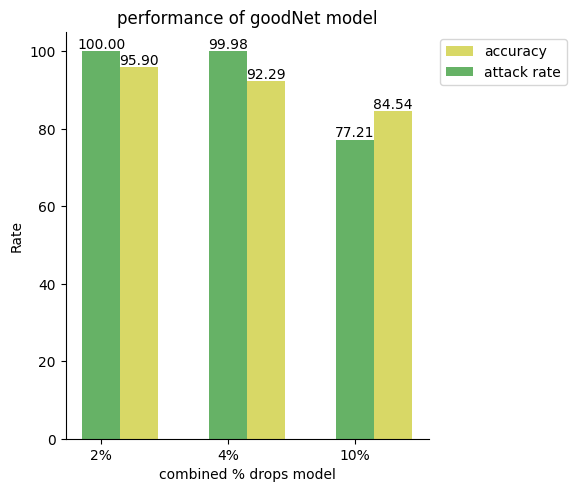

In [113]:
opacity = 0.6
bar_width = 0.3

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(A_t_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(A_t_accuracy)) + bar_width, A_t_accuracy, bar_width, align='center', alpha=opacity, color='y', label='accuracy')
bar2 = plt.bar(range(len(A_attack_rate)),A_attack_rate, bar_width, align='center', alpha=opacity, color='g', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()